# 00000: Model validation and optimization
Authors: Tobias G. Mueller, Mark A. Buckner
Last modified: 4 Dec 2024
Contact: __________

**Summary**: Here, we use the tiled model predictions as well as validate it against a labeled ground truth.
We then calculate the confidence threshold that optimizes f1 score and filter out main model predictions are that level.


This script outputs 
- an optimized model predicting on the whole orthomosaic
- model performance metrics

The data used in this script was generated in:
    `AIggregation/notebooks/02_predict_and_tile.ipynb`
    - labelstudio, labeling ground truth of the output from above script

Before running this script you must have ground truthed the tiled testset output from `02_predict_and_tile.ipynb` using label studio 

In [48]:
#imports 
import os
import fiftyone as fo
from fiftyone import ViewField as F
import scipy
import fiftyone as fo
import yaml

# first check the wd is not notebooks but the main folder
print("cwd is", os.getcwd())

if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
    print("cwd changed to", os.getcwd())


cwd is /home/tmueller/github/AIggregation


First we import the tiled predictions and corresponding ground truths that were annotated and remove any split boxes that were cropped during the tiling.

In [49]:

# set paths
# -------------------------------------------------------------------------------------------------------------------- #
gt_directory = "datasets/testset/groundtruth_testset"       # Directory with labelstudio groundtruth export extracted. Should contain "images" and "labels" folders
tiled_test_directory = "datasets/testset/tiled_testset"     # target folder for tile script ("target_path" in previous notebook)
# -------------------------------------------------------------------------------------------------------------------- #



# rename label studio outputs to have same name as fiftyone outputs (label studio adds long numeric strings upon export)
for root, dirs, files in os.walk(gt_directory):
    for file in files:
        oldname = os.path.join(root,file)
        if "-" in file:
            newname = file.split("-")[1]
            os.rename(oldname, os.path.join(root,newname))


# create a YAML file in the ground_truth folder 
folder = gt_directory.split('/')[-1] # get end of string (folder name)

data = {
    'names':{
    0: "nest"},
    'path': os.path.join("..", folder),
    'val': "./images/"
        }
with open((os.path.join(gt_directory,"dataset.yaml")), 'w') as outfile:
    yaml.dump(data, outfile, default_flow_style=False, sort_keys=False)




# import test tiles into fiftyone
datasettest = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(tiled_test_directory, "dataset.yaml"),
    label_field= "prediction"
)

# import groundtruthed tiles into fiftyone
dataset_ground = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(gt_directory,"dataset.yaml"),
    label_field= "ground_truth"
)

# merge the datasets, merging images/labels with the same file name
key_fcn = lambda sample: os.path.basename(sample.filepath)

datasettest.merge_samples(dataset_ground, key_fcn=key_fcn)



# delete any oblong box predictions
# these are created by splitting tiles through the middle of an existing bounding box. Nest predictions should not be oblong

# Compute the dimensions of each bounding box in pixels
box_width, box_height = F("bounding_box")[2], F("bounding_box")[3]

# remove detections where one side of the box is greater than 2.5 time the other
def get_label_fields(sample_collection):
    """Get the (detection) label fields of a Dataset or DatasetView."""
    label_fields = list(
        sample_collection.get_field_schema(embedded_doc_type=fo.Detections).keys()
    )
    return label_fields


for lf in get_label_fields(datasettest):
    datasettest_temp = datasettest.filter_labels(
    "prediction", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False)


for lf in get_label_fields(datasettest_temp):
    datasettest_keep = datasettest_temp.filter_labels(
    "ground_truth", (box_height < (box_width*2)) & (box_width < (box_height*2)), only_matches=False)





 100% |█████████████████| 116/116 [194.6ms elapsed, 0s remaining, 596.0 samples/s]      
 100% |█████████████████| 116/116 [143.8ms elapsed, 0s remaining, 817.1 samples/s] 
Indexing dataset...
 100% |█████████████████| 116/116 [71.6ms elapsed, 0s remaining, 1.6K samples/s] 
Merging samples...
 116 [440.9ms elapsed, ? remaining, 264.0 samples/s] 



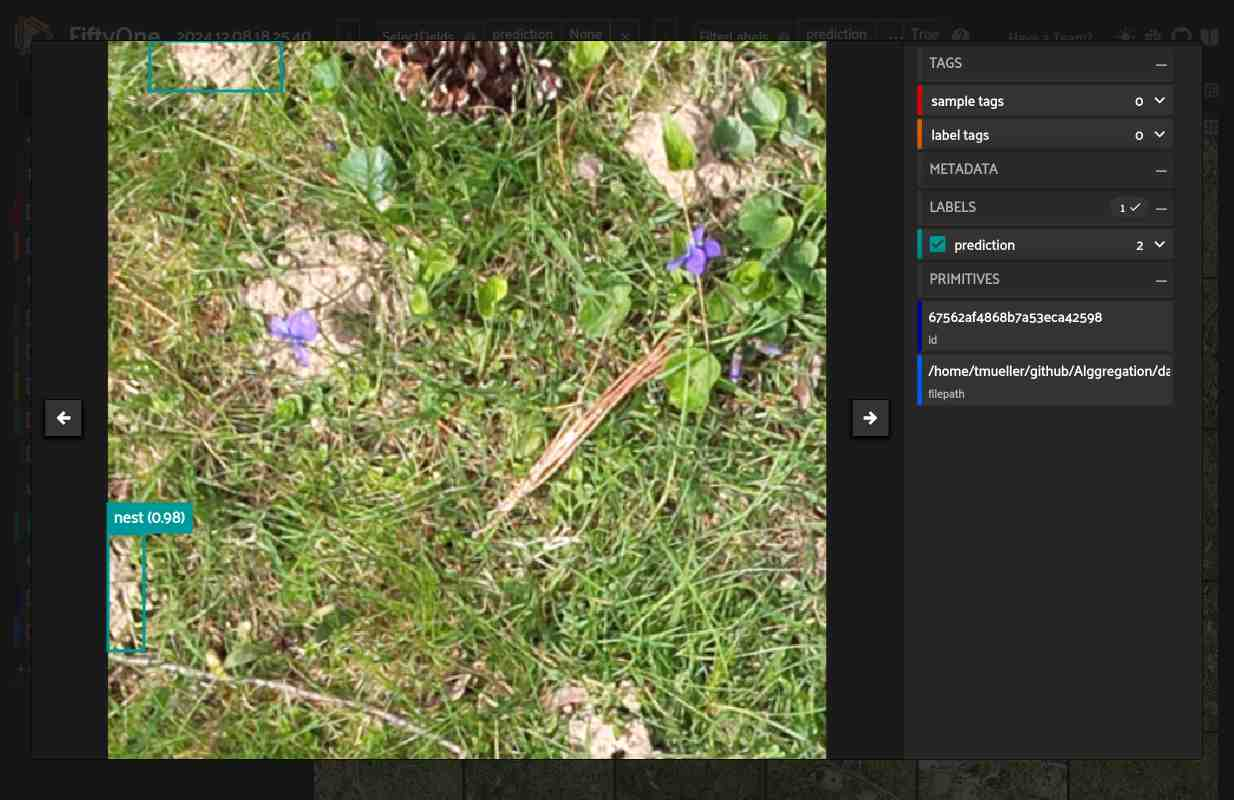

In [ ]:
# create a subset view of just boxes that were removed for visualization 
removed_boxes=datasettest.select_fields("prediction").filter_labels(
    "prediction", (box_height > (box_width*2)) | (box_width > (box_height*2)) 
)

session = fo.launch_app(removed_boxes)


We can then use the ground truths to validate our model predictions. 

Each detection made by the model has a confidence associated with it. We will filter at the confidence threshold that leads to the highest F1 score (the harmonic mean between recall and precision) to get the best overall model

In [50]:
# set parameters
# -------------------------------------------------------------------------------------------------------------------- #
dataset = datasettest_keep      # filtered dataset 
prediction = "prediction"       # prediction name
gt = "ground_truth"             # ground truth name
lb = .1                         # lower confidence to check between
ub = .99                        # upper confidence to check between
iou = 0.4                       # what IOU to use for FN and FP detections
# -------------------------------------------------------------------------------------------------------------------- #



# define function to calculate the f1 score of a model
def calculate_f1(conf, dataset, prediction, gt):
    conf_view = dataset.filter_labels(prediction, F("confidence") >= conf)
    results = conf_view.evaluate_detections(prediction,
        gt_field= gt,
        eval_key="eval",
        missing="fn",
        iou = iou)

    fp = sum(conf_view.values("eval_fp"))
    tp = sum(conf_view.values("eval_tp"))
    fn = sum(conf_view.values("eval_fn"))

    f1 = tp/(tp+0.5*(fp+fn))

    return -1.0*f1  #make output negative to use fminbound in following function

calculate_f1(dataset=dataset, conf=.5, prediction=prediction, gt=gt)


# define function find the optimal output of the above function
def optimize_conf(lb, ub, dataset, gt, prediction):

    res = scipy.optimize.fminbound(
                    func=calculate_f1,
                    x1=lb,
                    x2=ub,
                    args=(dataset, prediction, gt),
                    xtol=0.01,
                    full_output=True
    )

    best_conf, f1val, ierr, numfunc = res
    maxf1 = -1.0*f1val
    print("\n \n     best f1          at confidence")
    print(maxf1, best_conf)
    return maxf1, best_conf


# save second output, best_conf, to a variable for use in filtering predictions
bestconf = optimize_conf(lb=lb, ub=ub, dataset=dataset, gt=gt, prediction=prediction)[1]


# filter and evaluate model performance at best conf threshold
high_f1_view = datasettest_keep.filter_labels("prediction", F("confidence") > bestconf, only_matches=False)





Evaluating detections...
 100% |█████████████████| 101/101 [380.4ms elapsed, 0s remaining, 265.5 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [386.4ms elapsed, 0s remaining, 261.4 samples/s]      
Evaluating detections...
 100% |███████████████████| 99/99 [404.0ms elapsed, 0s remaining, 245.1 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [382.7ms elapsed, 0s remaining, 263.9 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [537.2ms elapsed, 0s remaining, 188.0 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [376.1ms elapsed, 0s remaining, 268.5 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [430.3ms elapsed, 0s remaining, 234.7 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [430.6ms elapsed, 0s remaining, 234.5 samples/s]      
Evaluating detections...
 100% |█████████████████| 101/101 [396.8ms elapsed, 0s remainin

Now that we have our model filtered to optimized F1, we can evaluate its performance

In [ ]:
results_f1 = high_f1_view.evaluate_detections(
    prediction,
    gt_field=gt,
    eval_key="prediction",
    missing = "fn",
    iou = iou,
    compute_mAP=True
)

# print performance results
print("\n \n model mAP:", results_f1.mAP(), "\n \n")

results_f1.print_report()


# Plot a precision recall curve
results_f1.plot_pr_curves()



Evaluating detections...
 100% |█████████████████| 116/116 [418.7ms elapsed, 0s remaining, 277.1 samples/s]      
Performing IoU sweep...
 100% |█████████████████| 116/116 [434.5ms elapsed, 0s remaining, 267.0 samples/s]      

 
 model mAP: 0.4224649726074807 
 

              precision    recall  f1-score   support

        nest       0.94      0.82      0.88       292

   micro avg       0.94      0.82      0.88       292
   macro avg       0.94      0.82      0.88       292
weighted avg       0.94      0.82      0.88       292



AttributeError: type object 'DOMWidget' has no attribute '_ipython_display_'

FigureWidget({
    'data': [{'customdata': array([0.986552 , 0.8875144, 0.8858216, 0.8843432, 0.882377 , 0.8808262,
                                   0.8606358, 0.7843225, 0.7831913, 0.7822875, 0.7816808, 0.7807862,
                                   0.7802986, 0.7798719, 0.7794453, 0.7787239, 0.7777266, 0.7767071,
                                   0.7579351, 0.7439714, 0.6801225, 0.6795316, 0.6789836, 0.6784886,
                                   0.6781837, 0.677892 , 0.6773308, 0.6769215, 0.6761448, 0.6757359,
                                   0.6750527, 0.6741505, 0.6735244, 0.6723846, 0.6715143, 0.66791  ,
                                   0.6657815, 0.6559819, 0.6519316, 0.6433469, 0.5761188, 0.5755681,
                                   0.5750965, 0.5744546, 0.5736087, 0.5725509, 0.5717482, 0.5701388,
                                   0.5675414, 0.5651289, 0.5598644, 0.55506  , 0.5512955, 0.5476143,
                                   0.5374216, 0.5245648, 0.4665482, 0.4609104, 0.4550543, 0.4516936,
                                   0.4461805, 0.4403891, 0.432287 , 0.4209353, 0.4124019, 0.3971543,
                                   0.3463497, 0.3386409, 0.3288952, 0.3211473, 0.3040368, 0.2923654,
                                   0.2771772, 0.2165027, 0.2026595, 0.1936302, 0.1744476, 0.1158254,
                                   0.0562569, 0.0525983, 0.       , 0.       , 0.       , 0.       ,
                                   0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
                                   0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
                                   0.       , 0.       , 0.       , 0.       , 0.       ]),
              'hovertemplate': ('<b>class: %{text}</b><br>recal' ... 'customdata:.3f}<extra></extra>'),
              'line': {'color': '#FF6D04'},
              'mode': 'lines',
              'name': 'nest (AP = 0.422)',
              'text': array(['nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest', 'nest',
                             'nest', 'nest'], dtype='<U4'),
              'type': 'scatter',
              'uid': 'dafcaee4-b167-42b5-a05c-1189663b598d',
              'x': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
                          0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22, 0.23,
                          0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33, 0.34, 0.35,
                          0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47,
                          0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59,
                          0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69, 0.7 , 0.71,
                          0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83,
                          0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95,
      

We can then view the false negatives and false positives to get a better understanding of when the model is not accurate


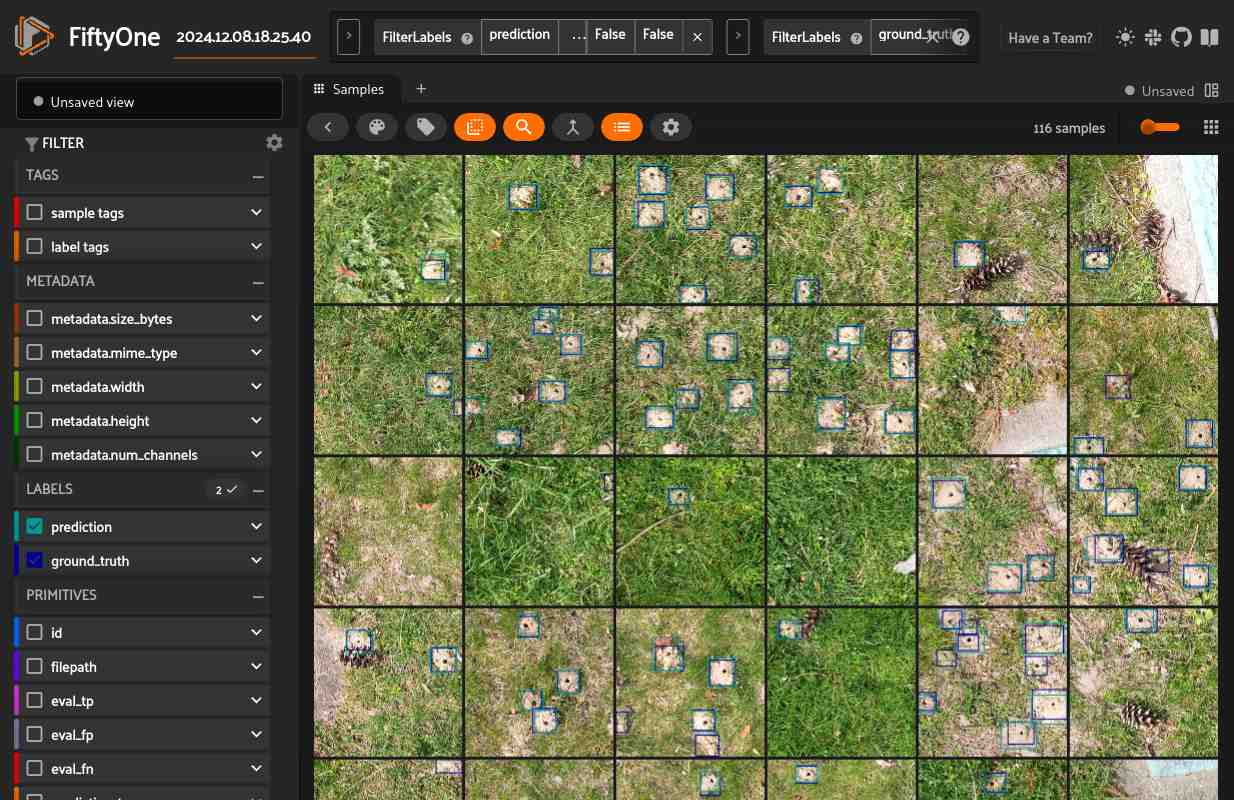

In [ ]:
#view false postivies

fp_view = high_f1_view.to_evaluation_patches(eval_key="prediction").match(F("type")=="fp").sort_by("prediction.detection.confidence")

session.view = fp_view.view()


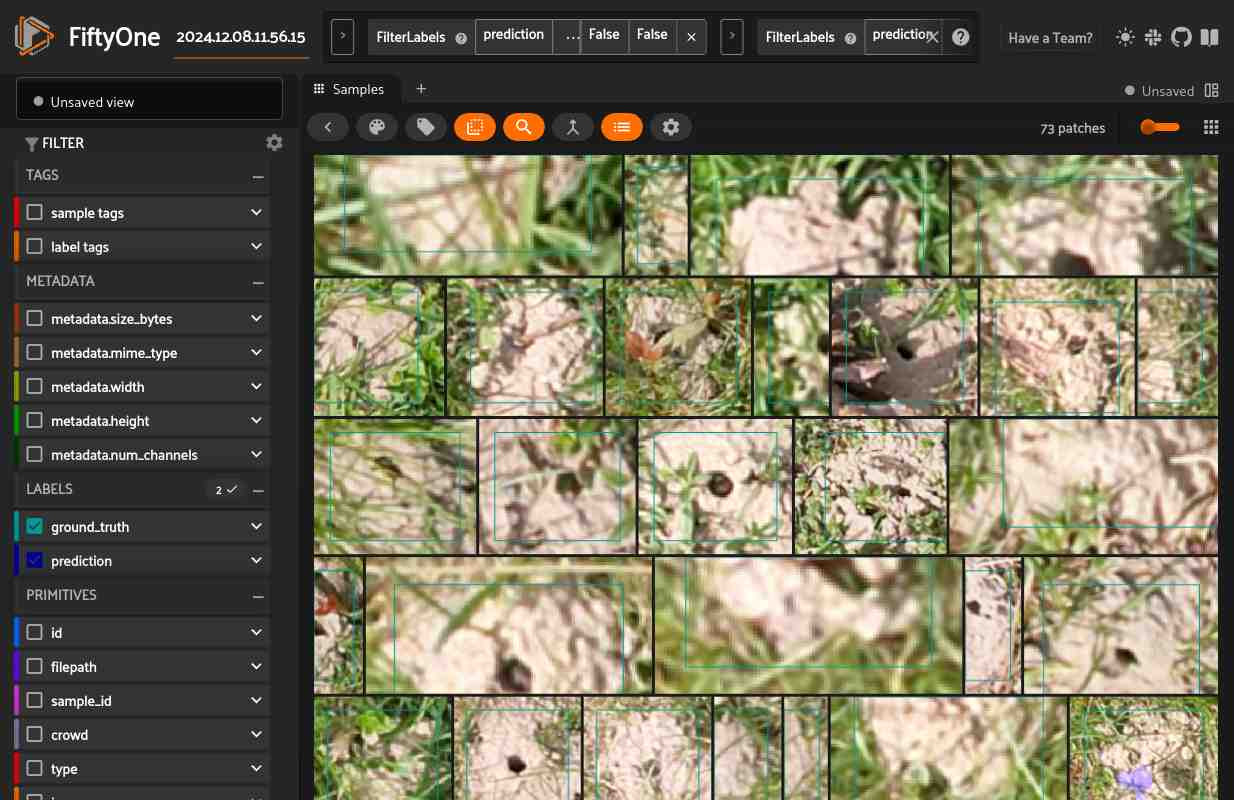

In [ ]:
#view false negatives

fn_view = high_f1_view.to_evaluation_patches(eval_key="prediction").match(F("type")=="fn").sort_by("prediction.detection.confidence")

session.view = fn_view.view()

Lastly we will filter our full model detections at the optimized confidence threshold and export the detections

In [55]:
# set paths
# -------------------------------------------------------------------------------------------------------------------- #
full_prediction_directory = "datasets/export_predictions/temp"      # directory with model detections (created in 02_predict_and_tile.ipynb)
full_export_directory = "datasets/export_predictions/final"         # directory to output optimized detections
# -------------------------------------------------------------------------------------------------------------------- #


# read in full sahi predictions
dataset_final = fo.Dataset.from_dir(
    dataset_type=fo.types.YOLOv5Dataset,
    yaml_path = os.path.join(full_prediction_directory, "dataset.yaml"),
    label_field= "prediction"
)

# filter at optimal confidence
dataset_full_f1 = dataset_final.filter_labels("prediction", F("confidence") > bestconf, only_matches=False)

# export as final prediction
dataset_full_f1.export(
        export_dir=full_export_directory,
        dataset_type=fo.types.YOLOv5Dataset,
        label_field="prediction",
        include_confidence=True
    )

 100% |█████████████████████| 1/1 [512.9ms elapsed, 0s remaining, 2.0 samples/s] 
 100% |█████████████████████| 1/1 [768.4ms elapsed, 0s remaining, 1.3 samples/s] 


We now have optimized nest detections across our whole orthomosaic as well as metrics for how well our model is performing. 

The model detections can now be georeferenced in `04_georeference.ipynb` 